In [10]:
!pip install opencv-python-headless
!pip install pytesseract
!pip install numpy
!apt-get install tesseract-ocr
!tesseract --version


Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


'apt-get' is not recognized as an internal or external command,
operable program or batch file.


tesseract v5.5.0.20241111
 leptonica-1.85.0
  libgif 5.2.2 : libjpeg 8d (libjpeg-turbo 3.0.4) : libpng 1.6.44 : libtiff 4.7.0 : zlib 1.3.1 : libwebp 1.4.0 : libopenjp2 2.5.2
 Found AVX512BW
 Found AVX512F
 Found AVX512VNNI
 Found AVX2
 Found AVX
 Found FMA
 Found SSE4.1
 Found libarchive 3.7.7 zlib/1.3.1 liblzma/5.6.3 bz2lib/1.0.8 liblz4/1.10.0 libzstd/1.5.6
 Found libcurl/8.11.0 Schannel zlib/1.3.1 brotli/1.1.0 zstd/1.5.6 libidn2/2.3.7 libpsl/0.21.5 libssh2/1.11.0


In [11]:
pip install --user pytesseract opencv-python numpy tensorflow


Image loaded successfully.


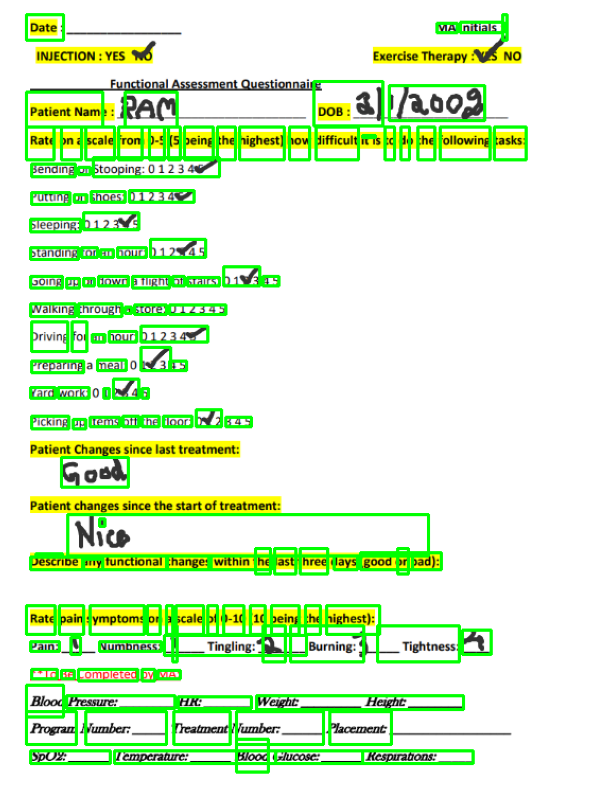

{
    "PATIENT DETAILS": {
        "PATIENT NAME": "RACY",
        "DOB": "Not Readable"
    },
    "TREATMENT DETAILS": {
        "DATE": "NA",
        "INJECTION": "NO",
        "EXERCISE THERAPHY": "NO"
    },
    "DIFFICULTY RATINGS": {
        "Bending or Stooping": 5,
        "Putting on shoes": 5,
        "Sleeping": "Unmarked",
        "Standing for an hour": 3,
        "Walking through a store": "Unmarked",
        "Yard work": 3,
        "Picking up items off the floor": 1
    },
    "PATIENT CHANGES": {
        "SINCE LAST TREATMENT": "Not Readable",
        "SINCE THE START OF TREATMENT": "Not Readable",
        "LAST 3 DAYS": "GOOD"
    },
    "PAIN SYMPTOMS": {
        "PAIN": 0,
        "NUMBNESS": 0,
        "TINGLING": 0,
        "BURNING": 0,
        "TIGHTNESS": 0
    },
    "MEDICAL ASSISTANT(MA) INPUTS": {
        "BLOOD PRESSURE": "NA",
        "HR": "_",
        "WEIGHT": "NA",
        "HEIGHT": "NA",
        "SPO2": "NA",
        "TEMPERATURE": "NA",
        "BL

In [13]:
import pytesseract
import cv2
import numpy as np
import heapq
import re
import json
import matplotlib.pyplot as plt

pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

img = cv2.imread("imageonline-co-writeimage (2).jpg")

if img is None:
    print("Error: Image not found or unable to load.")
else:
    print("Image loaded successfully.")

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    thresh_img = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
    denoised = cv2.fastNlMeansDenoising(thresh_img, None, 30, 7, 21)
    kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
    sharpened_img = cv2.filter2D(denoised, -1, kernel)

    myconfig = r"--psm 6 --oem 3"
    data = pytesseract.image_to_data(sharpened_img, config=myconfig, output_type=pytesseract.Output.DICT)

    recognized_words = []
    previous_y = -1
    lines_text = []

    for i in range(len(data['text'])):
        text = data['text'][i].strip()
        if text != "":
            x, y, w, h = data['left'][i], data['top'][i], data['width'][i], data['height'][i]
            img = cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)

            if previous_y != -1 and abs(previous_y - y) > 10:
                lines_text.append(' '.join(recognized_words))
                recognized_words = []

            recognized_words.append(text)
            previous_y = y

    if recognized_words:
        lines_text.append(' '.join(recognized_words))

        plt.figure(figsize=(10, 10))
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()

    def check_for_missing_number(line):
        numbers = ['1', '2', '3', '4', '5']
        line_numbers = [num for num in numbers if num in line]
        missing_numbers = [num for num in numbers if num not in line]

        max_heap = []
        for num in missing_numbers:
            heapq.heappush(max_heap, -int(num))

        return max_heap

    target_lines = [
        "Bending or Stooping", "Putting on shoes", "Sleeping", "Standing for an hour",
        "Going up or down a flight of stairs", "Walking through a store", "Driving for an hour",
        "Preparing a meal", "Yard work", "Picking up items off the floor"
    ]

    patient_name = None
    all_text = ' '.join(lines_text)
    words = all_text.split()

    for i, word in enumerate(words):
        if word.lower() == "manta" and i + 1 < len(words):
            patient_name = words[i + 1]
            break

    pain_terms = ['Pain', 'Numbness', 'Tingling', 'Burning', 'Tightness']
    pain_values = {term: 0 for term in pain_terms}

    for term in pain_terms:
        term_pattern = re.compile(rf"({term})\s*(\d?)")
        match = term_pattern.search(all_text)
        if match:
            pain_values[term] = int(match.group(2)) if match.group(2) else 0

    additional_terms = [
        "DOB:", "DATE:", "INJECTION:", "EXERCISE_THERAPHY:", "PATIENT CHANGES:", "SINCE LAST TREATMENT:",
        "SINCE START OF TREATMENT", "LAST 3 DAYS", "MEDICAL ASSISTANT", "BLOOD PRESSURE:", "HR:", "WEIGHT:",
        "HEIGHT:", "SPO2:", "TEMPERATURE:", "BLOOD GLUCOSE:", "RESPIRATION:"
    ]
    default_values = {
        "DOB:": "Not Readable", "DATE:": "NA", "INJECTION:": "NO", "EXERCISE_THERAPHY:": "NO", "PATIENT CHANGES:": "Not Readable",
        "SINCE LAST TREATMENT:": "Not Readable", "SINCE START OF TREATMENT": "Not Readable", "LAST 3 DAYS": "GOOD",
        "MEDICAL ASSISTANT": "Not Readable", "BLOOD PRESSURE:": "NA", "HR:": "NA", "WEIGHT:": "NA", "HEIGHT:": "NA",
        "SPO2:": "NA", "TEMPERATURE:": "NA", "BLOOD GLUCOSE:": "NA", "RESPIRATION:": "NA"
    }
    additional_values = {term: default_values.get(term, "Not Readable") for term in additional_terms}

    for term in additional_terms:
        term_pattern = re.compile(rf"({term})\s*(\S.*?)")
        match = term_pattern.search(all_text)
        if match:
            additional_values[term] = match.group(2)

    extracted_data = {
        "PATIENT DETAILS": {
            "PATIENT NAME": patient_name if patient_name else "Not Found",
            "DOB": additional_values.get("DOB:", "Not Readable")
        },
        "TREATMENT DETAILS": {
            "DATE": additional_values.get("DATE:", "Not Readable"),
            "INJECTION": additional_values.get("INJECTION:", "NO"),
            "EXERCISE THERAPHY": additional_values.get("EXERCISE_THERAPHY:", "NO")
        },
        "DIFFICULTY RATINGS": {},
        "PATIENT CHANGES": {
            "SINCE LAST TREATMENT": additional_values.get("SINCE LAST TREATMENT:", "Not Readable"),
            "SINCE THE START OF TREATMENT": additional_values.get("SINCE START OF TREATMENT", "Not Readable"),
            "LAST 3 DAYS": additional_values.get("LAST 3 DAYS", "GOOD")
        },
        "PAIN SYMPTOMS": {
            "PAIN": pain_values['Pain'],
            "NUMBNESS": pain_values['Numbness'],
            "TINGLING": pain_values['Tingling'],
            "BURNING": pain_values['Burning'],
            "TIGHTNESS": pain_values['Tightness']
        },
        "MEDICAL ASSISTANT(MA) INPUTS": {
            "BLOOD PRESSURE": additional_values.get("BLOOD PRESSURE:", "NA"),
            "HR": additional_values.get("HR:", "NA"),
            "WEIGHT": additional_values.get("WEIGHT:", "NA"),
            "HEIGHT": additional_values.get("HEIGHT:", "NA"),
            "SPO2": additional_values.get("SPO2:", "NA"),
            "TEMPERATURE": additional_values.get("TEMPERATURE:", "NA"),
            "BLOOD GLUCOSE": additional_values.get("BLOOD GLUCOSE:", "NA"),
            "RESPIRATIONS": additional_values.get("RESPIRATION:", "NA")
        }
    }

    for target in target_lines:
        for line in lines_text:
            if target in line:
                missing_number_heap = check_for_missing_number(line)
                if missing_number_heap:
                    first_missing_number = -heapq.heappop(missing_number_heap)
                    extracted_data["DIFFICULTY RATINGS"][target] = first_missing_number
                else:
                    extracted_data["DIFFICULTY RATINGS"][target] = "Unmarked"
                break

    json_output = json.dumps(extracted_data, indent=4)
    print(json_output)

    generate_sql_file([extracted_data], "Patient.sql")
